Import libraries and init wandb for loss and accuracy tracking

In [1]:
import wandb

wandb.init(project="test3", entity="xhradskyp")

wandb: Currently logged in as: xhradskyp. Use `wandb login --relogin` to force relogin


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchvision
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from datetime import datetime
from torch.utils.data import random_split
from torchmetrics.functional import dice
from sklearn.metrics import roc_curve
from sklearn.utils.multiclass import type_of_target

In [3]:
# CONSTANTS

EPOCHS = 2
LR = 0.01
BATCH = 32
IMAGE_SAMPLE = 123
PATH_IMAGES = "data/images.npy"
PATH_LABELS = "data/labels.npy"
OPTION = "test" # "train"/"test"
SAVE_NAME = "Unet_FINAL_1"
LOAD_NAME = "unet_bce_adam_01_32_1"

Create an Unet class and init the model with 1 in channel and 3 out channels

In [4]:
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

net = UNET(3, 1)

Prepare the data into Dataset object. 

All the classes in labels are set to 1, extract blocks function makes 64x64px overlapping patches from those images

In [5]:
def extract_blocks(images):
    count,M,N,ch = images.shape
    w, h = 64, 64
    new = np.empty((count*49, w, h, ch), dtype=np.uint8)
    i = 0
    for image in images:
        for j in range(7):
            for k in range(7):
                new[i] = image[k*32:(k+1)*64-k*32, j*32:(j+1)*64-j*32]
                i += 1
    return new

class MyDataset(Dataset):
    def __init__(self):
        images = np.load(PATH_IMAGES)
        labels = np.load(PATH_LABELS)
        
        images = extract_blocks(images)
        print("done")
        labels = extract_blocks(labels)
        print("done")
        labels = labels[..., 1]
        labels[labels >= 1] = 1
        print("done")
        
        images = torch.tensor(images)
        labels = torch.tensor(labels)
        print(images.shape)
        self.images = images.permute((0, 3, 1, 2))
        self.labels = labels

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return self.images.shape[0]

In [6]:
dataset = MyDataset()

done
done
done
torch.Size([244069, 64, 64, 3])


Visualize the sample of image and mask from dataset

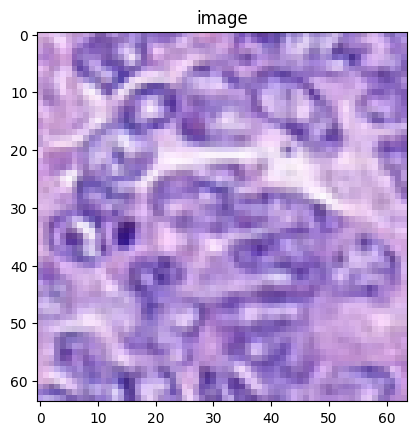

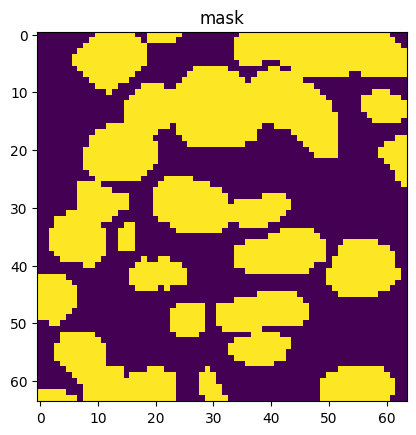

In [7]:
x = IMAGE_SAMPLE
plt.imshow(dataset[x][0].float().permute((1, 2, 0)).detach().numpy()/255)
plt.title("image")
plt.show()
plt.imshow(dataset[x][1].float().detach().numpy())
plt.title("mask")
plt.show()

Split the dataset to train (200000) and test (44069) and create dataloader with batch size of 32 (or 64) and shuffled data

In [8]:
train_data, test_data = random_split(dataset, [200000, len(dataset)-200000])
dataloader = DataLoader(dataset=train_data, batch_size=BATCH, shuffle=True)

Prepare constants, functions and model for training.

 - epochs: 2
 - model: UNET
 - loss function: BCEWithLogitsLoss
 - optimizer: Adam with learning rate 0.01 (or 0.001)

In [9]:
if OPTION == "train":
    num_epochs = EPOCHS
    total_samples = len(train_data)
    n_iterations = math.ceil(total_samples/BATCH)
    print(total_samples, n_iterations)
    net = UNET(3, 1)
    loss_fn = nn.BCEWithLogitsLoss()
    opt = torch.optim.Adam(net.parameters(), lr=LR)
    def acc_metric(predb, yb):
        return (predb.argmax(dim=1) == yb).float().mean()

Training the model, logging the loss and accuracy.

Visualize training sample every 200 steps.

In [10]:
if OPTION == "train":
    start_time = datetime.now()
    for epoch in range(num_epochs):
        avg_loss = 0
        for i, (inputs, labels) in enumerate(dataloader):
            opt.zero_grad()
            outputs = net(inputs.float())
            loss = loss_fn(outputs.squeeze(1), labels.float())

            loss.backward()
            opt.step()
            acc = acc_metric(outputs, labels)
            wandb.log({"loss": loss})
            wandb.log({"acc": acc})
            avg_loss += loss.item()
            if (i+1) % 20 == 0:
                print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_iterations}, loss {avg_loss/20}, acc {acc}, time {(datetime.now()-start_time)}')
                avg_loss = 0
            if (i+1) % 200 == 0:
                plt.imshow(inputs[0].permute((1, 2, 0)).detach().numpy()/255)
                plt.show()
                plt.imshow(outputs[0][0].detach().numpy())
                plt.show()
                plt.imshow(labels[0].detach().numpy())
                plt.show()

Save (and load) the trained model.

In [11]:
if OPTION == "train":
    torch.save(net, SAVE_NAME)

Init empty arrays for calculating best threshold

Calculate the dice metric on testing data and calculating the best threshold.

Threshold is calculated as best of multiple thresholds, from -2 to 2 with step 0.1

In [ ]:
if OPTION == "test":
    net = UNET(3, 1)
    net = torch.load(LOAD_NAME)

    thresholds1 = []
    names = []
    for i in np.arange(-2, 2, 0.1):
        thresholds1.append([])
        names.append(np.round(i, 1))

    dataloader_test = DataLoader(dataset=test_data, batch_size=1, shuffle=True)
    total_dice = 0
    total_samples = len(test_data)
    n_iterations = math.ceil(total_samples/1)
    with torch.no_grad():
        start_time = datetime.now()
        for i, (features, labels) in enumerate(dataloader_test):
            outputs = net(features.float())
            total_dice += dice(outputs, labels)
            for j, key in enumerate(names):
                new_outputs = torch.clone(outputs)
                new_outputs[outputs < key] = 0
                new_outputs[outputs >= key] = 1
                thresholds1[j].append(dice(new_outputs, labels).item())
            if i % 1000 == 0:
                print(f'step {i} from {n_iterations} time {(datetime.now()-start_time)}')
    print(f'avg dice score: {total_dice / n_iterations}')

    thresholds1_copy = thresholds1.copy()
    for i, key in enumerate(names):
        thresholds1_copy[i] = sum(thresholds1[i])/len(thresholds1[i])
    
    plt.bar(names, thresholds1_copy, align='edge', width=0.08)
    print(names[thresholds1_copy.index(max(thresholds1_copy))])
    


Apply the threshold to generated mask and calculate the dice metric

In [ ]:
if OPTION == "test":
    trashhold = names[thresholds1_copy.index(max(thresholds1_copy))]

    new_outputs = torch.clone(outputs)

    new_outputs[outputs < threshold] = 0
    new_outputs[outputs >= threshold] = 1
    print(dice(new_outputs, labels))
    plt.imshow(new_outputs[0][0].detach().numpy())
    plt.title("generated mask")
    plt.show()
    plt.imshow(labels[0].detach().numpy())
    plt.title("ground truth mask")
    plt.show()

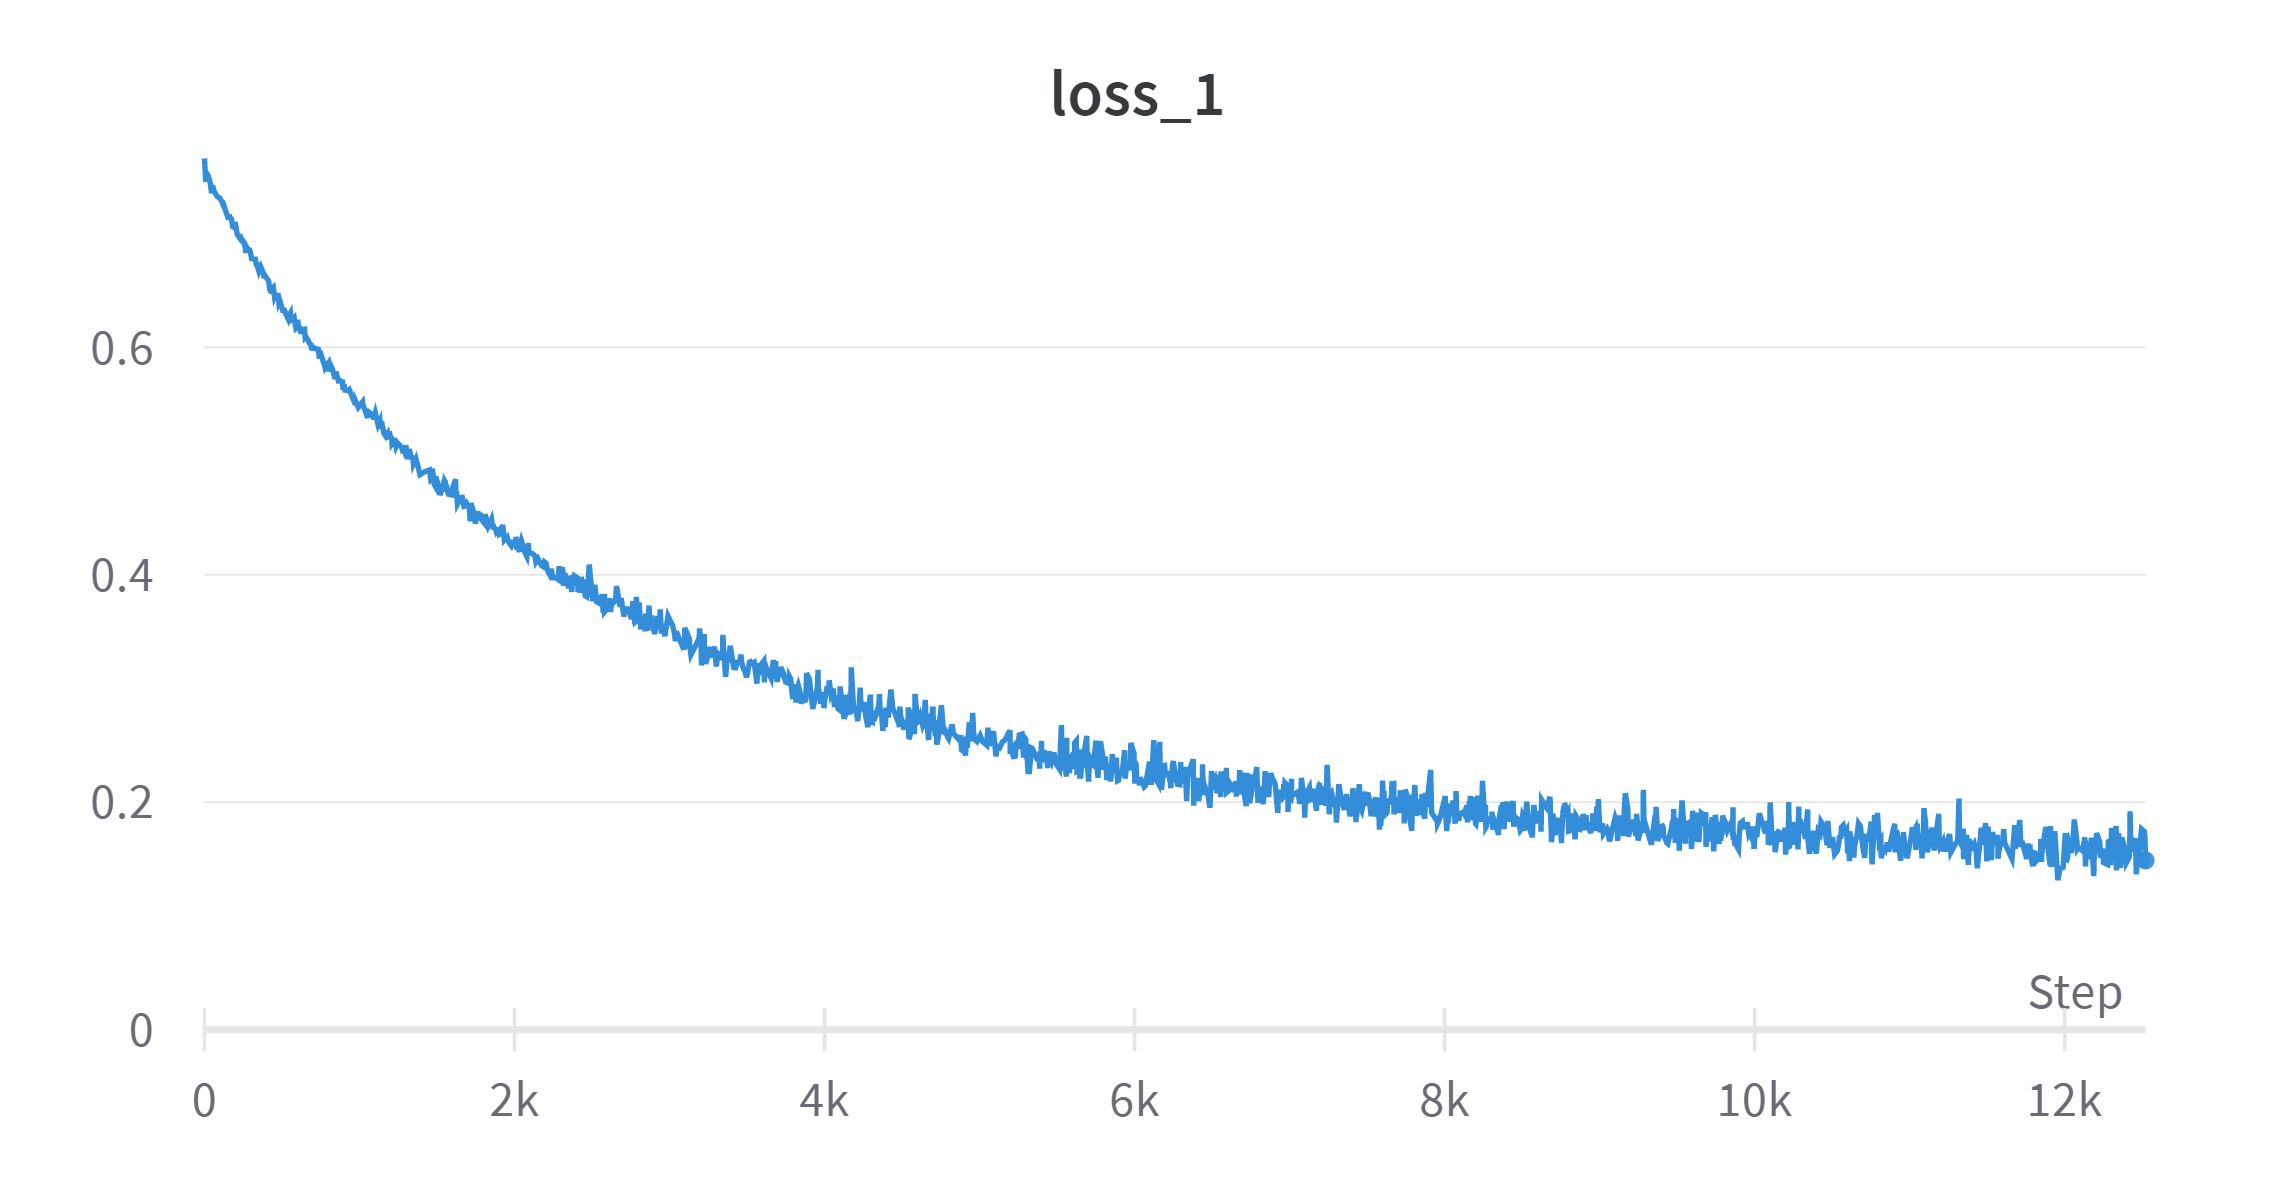

Trained for 2 epochs, final loss 0.16665339469909668 and total time 3:17:51.429321, avg dice score: 0.7841047644615173

batch 64, lr 0.001

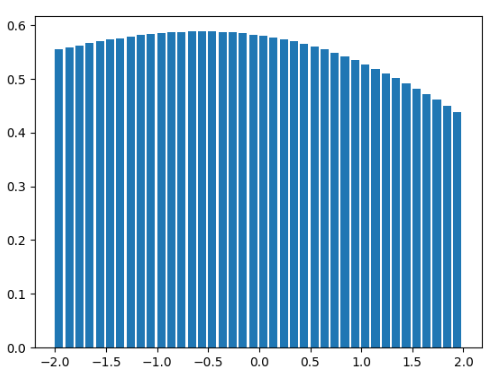

max: 0.6

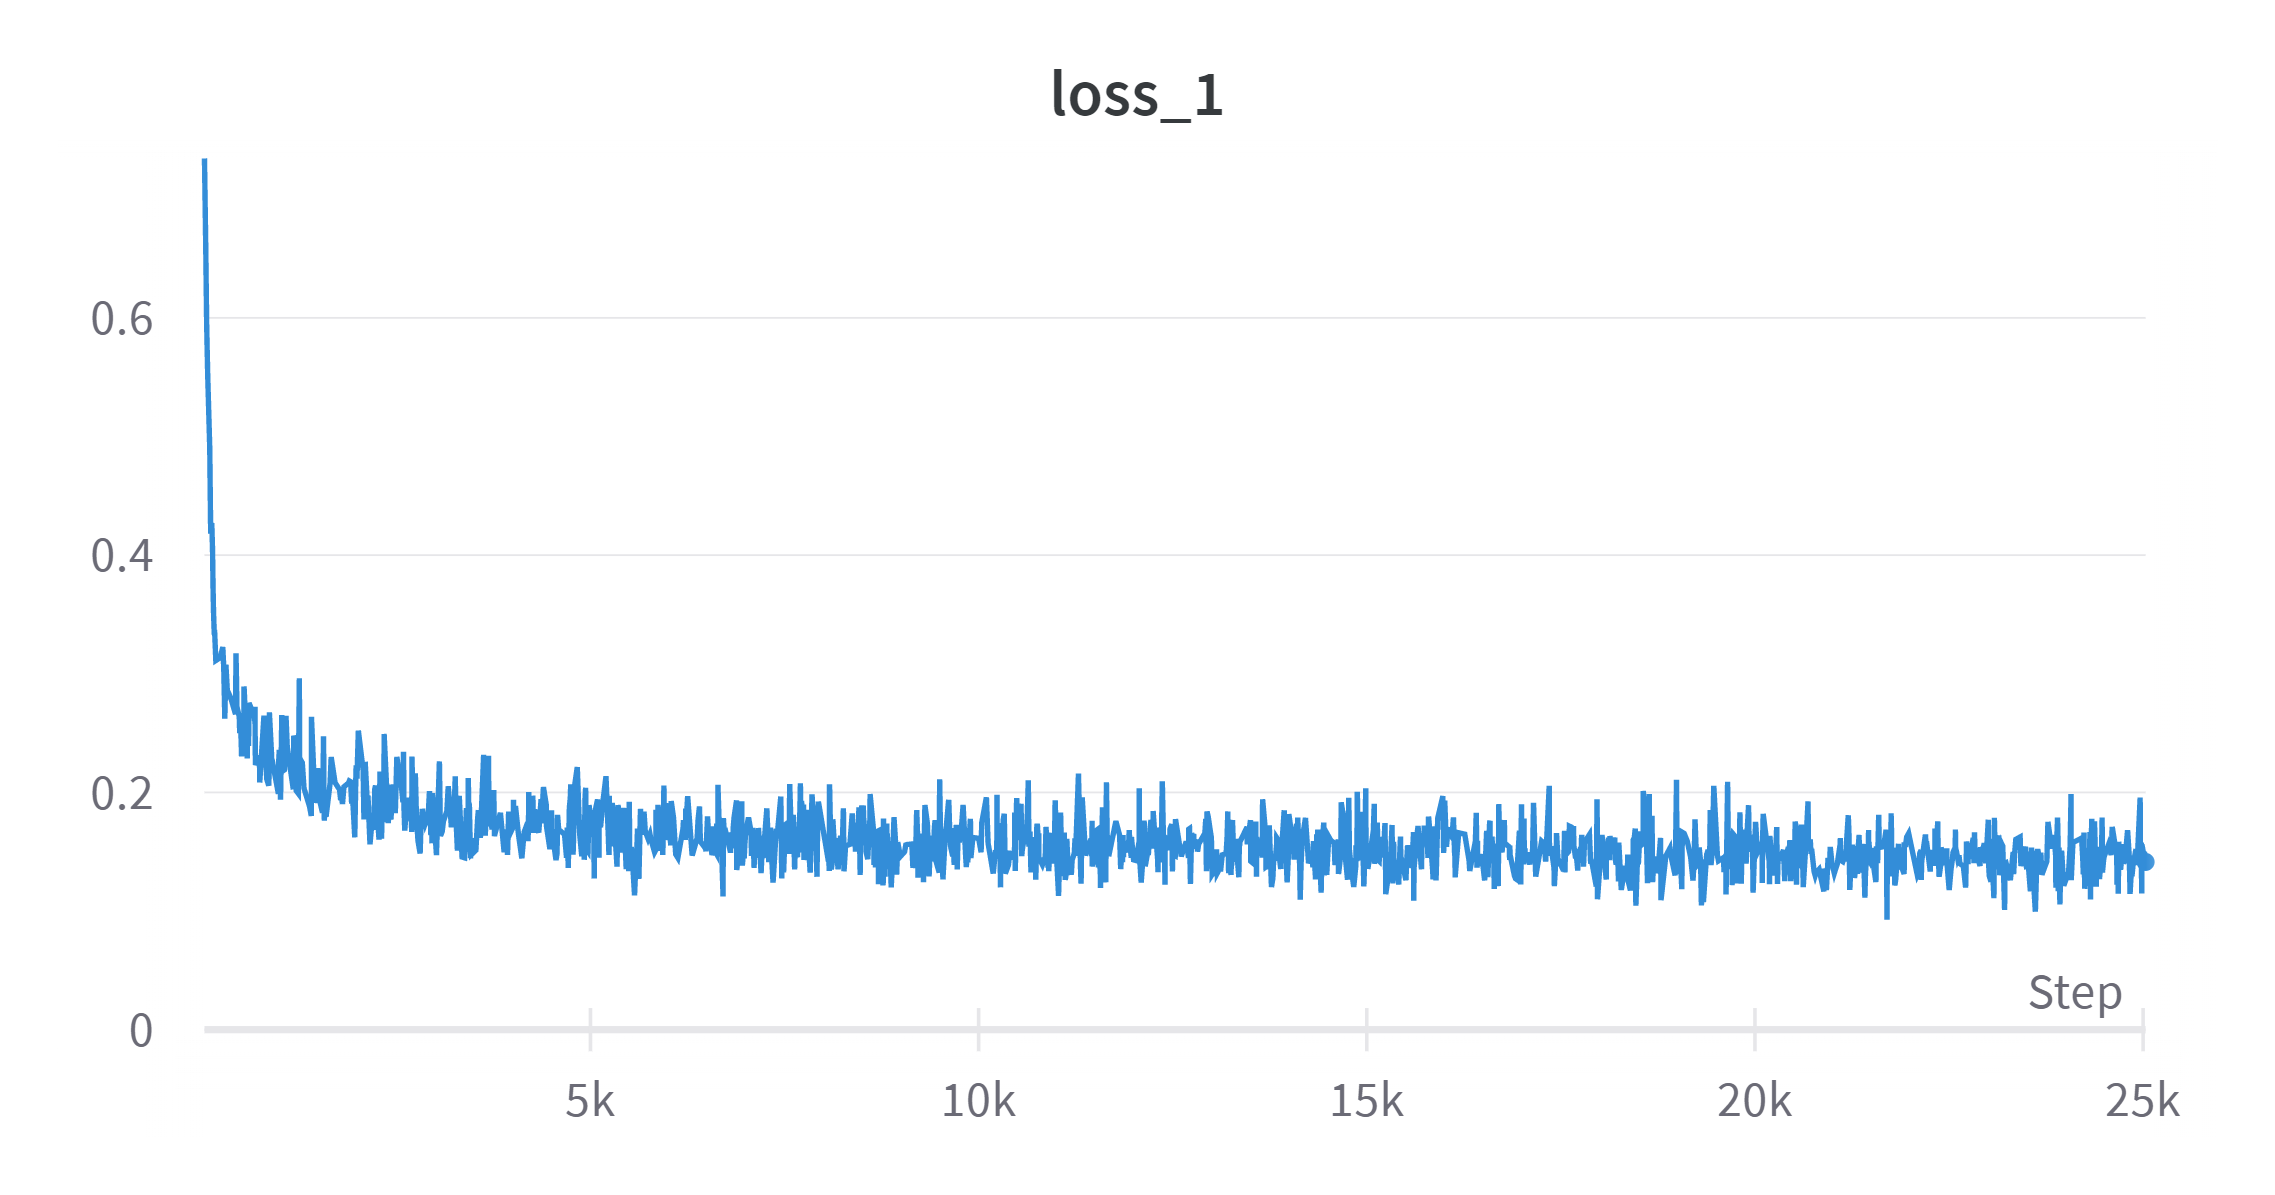

Trained for 2 epochs, final loss 0.15047740787267685 and total time 3:03:50.826795, avg dice score: 0.776847243309021

batch 32, lr 0.01

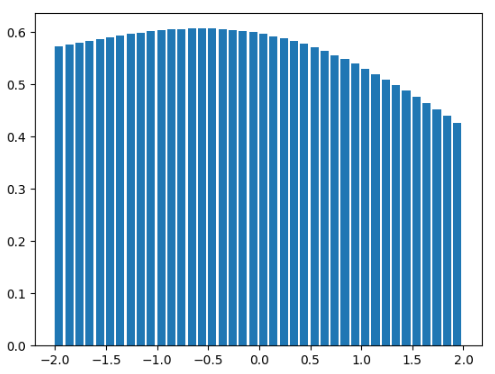

max: 0.6